## Import

In [83]:
# Import of basic packages
import numpy as np
import pandas as pd
import operator
import warnings

warnings.filterwarnings('ignore')

# Import of chart packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import altair as alt

# Import of machine learning metric packages
from sklearn.metrics import f1_score, classification_report, confusion_matrix, mean_squared_error, r2_score, accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, fbeta_score
from sklearn import metrics

# Import of preprossesor packages
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, LabelBinarizer, PolynomialFeatures

# Import of machine learning packages
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, VotingClassifier, StackingRegressor, StackingClassifier, AdaBoostClassifier
#from xgboost import XGBClassifier
from sklearn.svm import SVC

# Set random seed 
RSEED = 0

## Style

In [84]:
pd.set_option('display.max_columns', None)

## Load

In [85]:
# Load csv
df = pd.read_csv('data/train.csv')
df.head(3)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0


## Explore data analysis

In [86]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

,statistic,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,dtype,object,object,object,object,object,object,object,object,object,float64
1,mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.7
2,std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,117.1
3,min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
5,50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
6,75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.0
7,max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3451.0


In [87]:
# EDA duplicates
duplicates = df.duplicated().sum()
duplicate_percentage = round((duplicates / df.shape[0]) * 100, 1)
df[df.duplicated(keep=False)].head(10)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target


In [88]:
# EDA NaNs
missing = pd.DataFrame(df.isnull().sum(), columns=['Amount'])
missing['Percentage'] = round((missing['Amount']/df.shape[0]) * 100, 1)
missing[missing['Amount'] != 0]

,Amount,Percentage


In [89]:
# EDA shape
print('Number of rows and columns: ',df.shape)
print('-'*50)
pd.concat([df.head(3), df.tail(3)]).reset_index(drop=True)

Number of rows and columns:  (107833, 10)
--------------------------------------------------


,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_107830,2018-11-07,SGT 0000,TUN,TUN,2018-11-07 05:00:00,2018-11-07 12.50.00,SCH,TU 736IOK,0.0
4,train_id_107831,2018-01-23,UG 0010,TUN,DJE,2018-01-23 18:00:00,2018-01-23 18.45.00,ATA,TU CR9ISA,0.0
5,train_id_107832,2018-11-13,UG 0002,TUN,DJE,2018-11-13 06:15:00,2018-11-13 07.05.00,SCH,TU CR9ISA,0.0


In [90]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

,ID,STA,STD,FLTID,DATOP,target,DEPSTN,ARRSTN,AC,STATUS
Amount,107833,85136,81697,1861,1011,968,132,128,68,5


In [91]:
df.head(10)

,ID,DATOP,FLTID,DEPSTN,ARRSTN,STD,STA,STATUS,AC,target
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0
5,train_id_5,2016-01-17,TU 0283,TLS,TUN,2016-01-17 16:20:00,2016-01-17 18.15.00,ATA,TU 736IOP,53.0
6,train_id_6,2016-01-18,TU 0514,TUN,BCN,2016-01-18 07:15:00,2016-01-18 09.00.00,ATA,TU 32AIMH,10.0
7,train_id_7,2016-01-18,TU 0716,TUN,ORY,2016-01-18 07:35:00,2016-01-18 09.55.00,ATA,TU 32AIMI,15.0
8,train_id_8,2016-01-18,TU 0752,TUN,FCO,2016-01-18 07:40:00,2016-01-18 09.00.00,ATA,TU 32AIMC,16.0
9,train_id_9,2016-01-18,TU 0996,TUN,NCE,2016-01-18 07:45:00,2016-01-18 09.15.00,ATA,TU 31AIMK,21.0


In [92]:
# Get unique departure airports
df["DEPSTN"].unique()

array(['CMN', 'MXP', 'TUN', 'DJE', 'TLS', 'IST', 'ORY', 'MIR', 'BRU',
       'ABJ', 'VCE', 'AMS', 'FRA', 'BCN', 'JED', 'ALG', 'LIS', 'SXB',
       'LYS', 'OUA', 'LGW', 'BEY', 'NCE', 'OPO', 'MRS', 'DUS', 'SFA',
       'FCO', 'CDG', 'NKC', 'NTE', 'ZRH', 'GVA', 'OUD', 'MUC', 'SXF',
       'HAM', 'NDR', 'NBE', 'CAI', 'BEG', 'VIE', 'ORN', 'MAD', 'TOE',
       'BKO', 'DKR', 'KGL', 'BLQ', 'MLA', 'AHU', 'LHR', 'BOD', 'PRG',
       'LJU', 'SVO', 'MED', 'BUD', 'ARN', 'CPH', 'CRL', 'OST', 'TNG',
       'GAF', 'NAP', 'BRQ', 'OSR', 'YUL', 'NIM', 'TMR', 'JIB', 'CGN',
       'EBL', 'GAE', 'BJA', 'AYT', 'RAK', 'LFW', 'LIL', 'PMO', 'FBM',
       'TBJ', 'PSA', 'KRT', 'GNB', 'CZL', 'MVB', 'VNO', 'ESB', 'LBV',
       'CKY', 'LED', 'KSC', 'BTS', 'AMM', 'OTP', 'TRN', 'IEV', 'HBE',
       'CAG', 'KBP', 'ATH', 'SKG', 'ADB', 'DSS', 'DOH', 'COO', 'LUX',
       'FIH', 'BYJ', 'KEF', 'EBM', 'BDS', 'AAL', 'VKO', 'AAE', 'BRI',
       'VRN', 'SKX', 'HAJ', 'BLL', 'TLL', 'VOG', 'LAD', 'GHA', 'KTW',
       'SJJ', 'KRR',

In [93]:
# Get unique arrival airports
df["ARRSTN"].unique()

array(['TUN', 'IST', 'NTE', 'ALG', 'BCN', 'ORY', 'FCO', 'NCE', 'MRS',
       'MED', 'FRA', 'BRU', 'DJE', 'LYS', 'CMN', 'BEG', 'OUA', 'GVA',
       'MXP', 'BEY', 'MAD', 'JED', 'ABJ', 'VIE', 'MLA', 'BLQ', 'SFA',
       'LIS', 'LHR', 'CDG', 'MIR', 'CAI', 'DUS', 'HAM', 'NBE', 'ZRH',
       'AMS', 'NDR', 'TLS', 'VCE', 'SXB', 'MUC', 'LGW', 'CRL', 'ORN',
       'DKR', 'BOD', 'SXF', 'LJU', 'OST', 'NKC', 'BKO', 'TOE', 'AHU',
       'YUL', 'PRG', 'CPH', 'ARN', 'OUD', 'BRQ', 'GAF', 'JIB', 'BUD',
       'OPO', 'KGL', 'NIM', 'SVO', 'LIL', 'OSR', 'EBL', 'TNG', 'PSA',
       'CGN', 'AYT', 'GAE', 'NAP', 'BJA', 'KRT', 'LFW', 'TBJ', 'PMO',
       'TMR', 'FBM', 'RAK', 'GNB', 'ESB', 'CZL', 'LBV', 'KSC', 'CKY',
       'AMM', 'LED', 'BTS', 'MVB', 'HBE', 'OTP', 'CAG', 'VNO', 'TRN',
       'ATH', 'ADB', 'SKG', 'BYJ', 'DSS', 'COO', 'IEV', 'LUX', 'KBP',
       'DOH', 'FIH', 'EBM', 'BDS', 'VKO', 'AAE', 'BLL', 'HAJ', 'BRI',
       'CTA', 'VRN', 'SKX', 'VOG', 'BGY', 'LAD', 'KRR', 'SJJ', 'GHA',
       'RTM', 'TPS']

In [94]:
# Get dataframe for delayed flights
df_delayed = df.copy()
df_delayed = df_delayed[df_delayed["target"] > 0]
df_delayed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69665 entries, 0 to 107675
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      69665 non-null  object 
 1   DATOP   69665 non-null  object 
 2   FLTID   69665 non-null  object 
 3   DEPSTN  69665 non-null  object 
 4   ARRSTN  69665 non-null  object 
 5   STD     69665 non-null  object 
 6   STA     69665 non-null  object 
 7   STATUS  69665 non-null  object 
 8   AC      69665 non-null  object 
 9   target  69665 non-null  float64
dtypes: float64(1), object(9)
memory usage: 5.8+ MB


General statistics of target:
 count    107833.000000
mean         48.733013
std         117.135562
min           0.000000
25%           0.000000
50%          14.000000
75%          43.000000
max        3451.000000
Name: target, dtype: float64


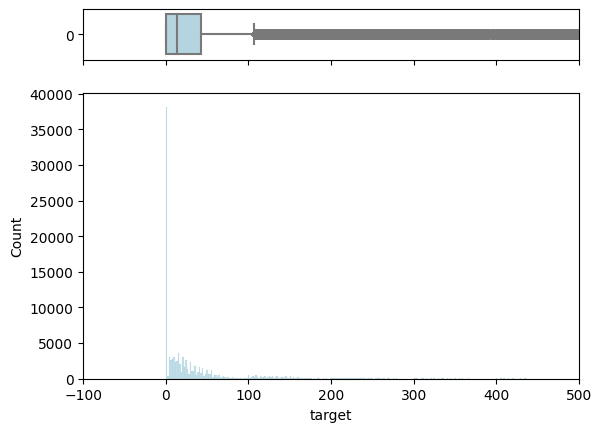

In [95]:
# Overview of target distribution
print("General statistics of target:\n", (df['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-100, 500])
plt.show()

General statistics of target (of delayed flights):
 count    69665.000000
mean        75.432814
std        138.650946
min          1.000000
25%         15.000000
50%         30.000000
75%         74.000000
max       3451.000000
Name: target, dtype: float64


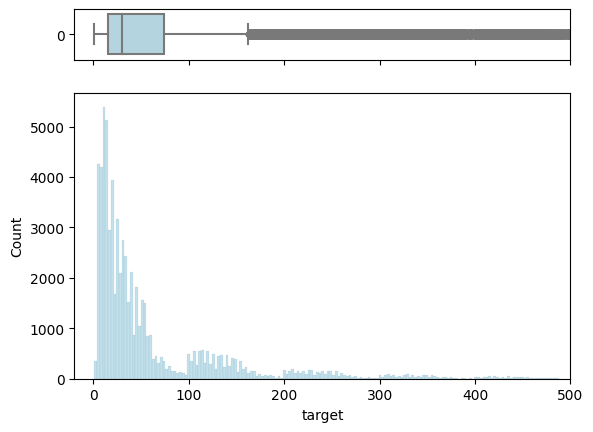

In [96]:
# Overview of target distribution (of delayed flights)
print("General statistics of target (of delayed flights):\n", (df_delayed['target']).describe())

# Creating a figure composed of two matplotlib.Axes objects (ax_box and ax_hist)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)})
 
# Assigning a graph to each ax
sns.boxplot(df_delayed["target"], orient="h", ax=ax_box, color='lightblue')
sns.histplot(data=df_delayed, x="target", ax=ax_hist, color='lightblue')

# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_box.set_xlim([-20, 500])
plt.show()

## Data cleaning

In [97]:
# Clean column names
df.columns = df.columns.str.replace(' ','_')
df.columns = df.columns.str.lower()

Feature 'ac' holds information about the model of the airplane. Extracting and converting the information.

In [98]:
df['airplane_model'] = df['ac'].str[3:6]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320


In [99]:
# EDA Uniques
unique_counts = pd.DataFrame(df.nunique(), columns=['Amount']).sort_values('Amount', ascending=False).T
unique_counts

,id,sta,std,fltid,datop,target,depstn,arrstn,ac,airplane_model,status
Amount,107833,85136,81697,1861,1011,968,132,128,68,16,5


In [100]:
set(df['airplane_model'])

{'319',
 '31A',
 '31B',
 '320',
 '321',
 '32A',
 '332',
 '343',
 '345',
 '733',
 '734',
 '736',
 '738',
 'AT7',
 'CR9',
 'M87'}

In [101]:
replacement_dict = {
    '31A': 'Airbus',
    '31B': 'Airbus',
    '320': 'Airbus',
    '321': 'Airbus',
    '32A': 'Airbus',
    '332': 'Airbus',
    '343': 'Airbus',
    '345': 'Airbus',
    '733': 'Boeing',
    '734': 'Boeing',
    '736': 'Boeing',
    'AT7': 'ATR',
    'CR9': 'Bombardier'
}

df['producer'] = df['airplane_model']

# Replace values in the 'purpose' column
df['producer'] = df['producer'].replace(replacement_dict)


In [102]:
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus


In [103]:
df['airline_1'] = df['fltid'].str[0:2]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU


In [104]:
set(df['airline_1'])

{'12',
 '20',
 '6Y',
 'A ',
 'AO',
 'AT',
 'AU',
 'C ',
 'D4',
 'DA',
 'GJ',
 'IN',
 'PR',
 'SG',
 'TU',
 'UG',
 'UH',
 'WK',
 'X9'}

In [105]:
df['airline_2'] = df['ac'].str[0:2]
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1,airline_2
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU,TU


In [106]:
set(df['airline_2'])

{'5K',
 '5M',
 '6P',
 'BJ',
 'D4',
 'GJ',
 'GW',
 'OL',
 'PS',
 'QS',
 'TU',
 'UG',
 'UJ',
 'X9'}

In [107]:
df.head()

,id,datop,fltid,depstn,arrstn,std,sta,status,ac,target,airplane_model,producer,airline_1,airline_2
0,train_id_0,2016-01-03,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016-01-03 12.55.00,ATA,TU 32AIMN,260.0,32A,Airbus,TU,TU
1,train_id_1,2016-01-13,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016-01-13 16.55.00,ATA,TU 31BIMO,20.0,31B,Airbus,TU,TU
2,train_id_2,2016-01-16,TU 0214,TUN,IST,2016-01-16 04:10:00,2016-01-16 06.45.00,ATA,TU 32AIMN,0.0,32A,Airbus,TU,TU
3,train_id_3,2016-01-17,TU 0480,DJE,NTE,2016-01-17 14:10:00,2016-01-17 17.00.00,ATA,TU 736IOK,0.0,736,Boeing,TU,TU
4,train_id_4,2016-01-17,TU 0338,TUN,ALG,2016-01-17 14:30:00,2016-01-17 15.50.00,ATA,TU 320IMU,22.0,320,Airbus,TU,TU


Load airpots data set and clean. 

Merge data sets based on airport short handle. 

In [108]:
# Add columns with weekdays, yyyy, mm, dd, hh:mm:ss

y = '_year'
m = '_month'
wd = '_wd'
M = '_min'

### std ###

date = 'std'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H:%M:%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int) # minutes
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### sta ###

date = 'sta'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d %H.%M.%S')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd
h = df[date].dt.strftime('%#H').astype(int) # hours
minutes = df[date].dt.strftime('%#M').astype(int)
# calcualte time in just minutes
t = 60*h + minutes
df.insert(loc=idx+4, column=date+M, value=t) # minutes

### datop ###

date = 'datop'

idx = df.columns.get_loc(date)

df[date] = pd.to_datetime(df[date], format='%Y-%m-%d')
df.insert(loc=idx+1, column=date+y, value=df[date].dt.strftime('%Y')) # year yyyy
df.insert(loc=idx+2, column=date+m, value=df[date].dt.strftime('%#m')) # month m
df.insert(loc=idx+3, column=date+wd, value=df[date].dt.strftime('%w')) # weekday wd

# convert new columns as integers
list = ['std_year', 'std_month', 'std_wd', 'sta_year', 'sta_month', 'sta_wd', 'datop_year', 'datop_month', 'datop_wd', 'target']

for date in list:
    df[date] = df[date].astype(int)

# change weekday numbers to EU where day 1 = Monday
list = ['std_wd', 'sta_wd', 'datop_wd']

for date in list:
    df[date][df[date] == 0] = 7 # Sunday

Geo-encoding of airports

In [109]:
# Load csv
df_airports = pd.read_csv('data/airports.csv')
df_airports.columns = ['id', 'name', 'city', 'country', 'short', 'rubbish_6', 'latitude', 'longitude', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'type', 'rubbish_5']
df_airports = df_airports.drop(['id', 'name', 'rubbish_1', 'rubbish_2', 'rubbish_3', 'rubbish_4', 'rubbish_5', 'rubbish_6', 'type'], axis=1)
df_airports = df_airports.dropna(subset=['short'])
df_airports.head(3)


,city,country,short,latitude,longitude
0,Pitt Meadows,Canada,\N,49.216099,-122.709999
1,Blida,Algeria,\N,36.503601,2.814170
2,Bou Saada,Algeria,\N,35.332500,4.206390


In [110]:
df = df.merge(df_airports, left_on='depstn', right_on='short', how='left', suffixes=('', '_dep'))

# Merge based on arrival station
df = df.merge(df_airports, left_on='arrstn', right_on='short', how='left', suffixes=('', '_arr'))

# Rename columns for clarity
df = df.rename(columns={
    'city': 'city_dep',
    'country': 'country_dep',
    'latitude': 'latitude_dep',
    'longitude': 'longitude_dep'
})

df.head(3)


,id,datop,datop_year,datop_month,datop_wd,fltid,depstn,arrstn,std,std_year,std_month,std_wd,std_min,sta,sta_year,sta_month,sta_wd,sta_min,status,ac,target,airplane_model,producer,airline_1,airline_2,city_dep,country_dep,short,latitude_dep,longitude_dep,city_arr,country_arr,short_arr,latitude_arr,longitude_arr
0,train_id_0,2016-01-03,2016,1,7,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016,1,7,630,2016-01-03 12:55:00,2016,1,7,775,ATA,TU 32AIMN,260,32A,Airbus,TU,TU,Casablanca,Morocco,CMN,33.3675,-7.58997,Tunis,Tunisia,TUN,36.851002,10.227200
1,train_id_0,2016-01-03,2016,1,7,TU 0712,CMN,TUN,2016-01-03 10:30:00,2016,1,7,630,2016-01-03 12:55:00,2016,1,7,775,ATA,TU 32AIMN,260,32A,Airbus,TU,TU,Casablanca,Morocco,CMN,33.3675,-7.58997,Tunis,Tunesia,TUN,36.847685,10.217603
2,train_id_1,2016-01-13,2016,1,3,TU 0757,MXP,TUN,2016-01-13 15:05:00,2016,1,3,905,2016-01-13 16:55:00,2016,1,3,1015,ATA,TU 31BIMO,20,31B,Airbus,TU,TU,Milano,Italy,MXP,45.6306,8.72811,Tunis,Tunisia,TUN,36.851002,10.227200


In [125]:
# Check if datum datop matches with datum std
df.shape

(197247, 35)

In [126]:
(df[(df["datop_year"]==df["std_year"])&(df["datop_month"]==df["std_month"])&(df["datop_wd"]==df["std_wd"])]).shape

(197247, 35)

In [29]:
# EDA info & describe
info = pd.concat([
df.dtypes.to_frame().T,
df.mean(numeric_only=True).to_frame().T,
df.std(numeric_only=True).to_frame().T,
df.min(numeric_only=True).to_frame().T,
df.quantile(0.25, numeric_only=True).to_frame().T,
df.quantile(0.5, numeric_only=True).to_frame().T, 
df.quantile(0.75, numeric_only=True).to_frame().T,
df.max(numeric_only=True).to_frame().T,], ignore_index=True).applymap(lambda x: round(x, 1) if isinstance(x, (int, float)) else x)

info.insert(0, 'statistic', ['dtype', 'mean', 'std', 'min', '25%', '50%', '75%', 'max'])
info

,statistic,id,datop,datop_year,datop_month,datop_wd,fltid,depstn,arrstn,std,std_year,std_month,std_wd,std_min,sta,sta_year,sta_month,sta_wd,sta_min,status,ac,target,airplane_model,producer,airline_1,airline_2,city_dep,country_dep,short,latitude_dep,longitude_dep,city_arr,country_arr,short_arr,latitude_arr,longitude_arr
0,dtype,object,datetime64[ns],int32,int32,int32,object,object,object,datetime64[ns],int32,int32,int32,int32,datetime64[ns],int32,int32,int32,int32,object,object,int32,object,object,object,object,object,object,object,float64,float64,object,object,object,float64,float64
1,mean,NaN,NaN,2017.0,6.6,4.1,NaN,NaN,NaN,NaN,2017.0,6.6,4.1,759.7,NaN,2017.0,6.6,4.1,793.3,NaN,NaN,47.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.4,8.9,NaN,NaN,NaN,38.4,8.9
2,std,NaN,NaN,0.8,3.3,2.0,NaN,NaN,NaN,NaN,0.8,3.3,2.0,315.7,NaN,0.8,3.3,2.0,334.4,NaN,NaN,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.2,8.4,NaN,NaN,NaN,7.1,8.4
3,min,NaN,NaN,2016.0,1.0,1.0,NaN,NaN,NaN,NaN,2016.0,1.0,1.0,0.0,NaN,2016.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-11.6,-73.7,NaN,NaN,NaN,-11.6,-73.7
4,25%,NaN,NaN,2016.0,4.0,2.0,NaN,NaN,NaN,NaN,2016.0,4.0,2.0,500.0,NaN,2016.0,4.0,2.0,580.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.8,6.8,NaN,NaN,NaN,36.8,6.8
5,50%,NaN,NaN,2017.0,7.0,4.0,NaN,NaN,NaN,NaN,2017.0,7.0,4.0,760.0,NaN,2017.0,7.0,4.0,795.0,NaN,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.9,10.2,NaN,NaN,NaN,36.9,10.2
6,75%,NaN,NaN,2018.0,9.0,6.0,NaN,NaN,NaN,NaN,2018.0,9.0,6.0,985.0,NaN,2018.0,9.0,6.0,1050.0,NaN,NaN,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.4,10.2,NaN,NaN,NaN,43.4,10.2
7,max,NaN,NaN,2018.0,12.0,7.0,NaN,NaN,NaN,NaN,2018.0,12.0,7.0,1439.0,NaN,2019.0,12.0,7.0,1439.0,NaN,NaN,3451.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,51.6,NaN,NaN,NaN,59.8,51.6


## Feature engineering

In [30]:
df = df.drop(['datop', 'fltid', 'std', 'sta', 'ac', 'short', 'short_arr', 'city_dep', 'country_dep', 'city_arr', 'country_arr'], axis=1)

# aggressive feature drop
df = df.drop(['airplane_model', 'producer', 'airline_2'], axis=1)


df.head(3)

,id,datop_year,datop_month,datop_wd,depstn,arrstn,std_year,std_month,std_wd,std_min,sta_year,sta_month,sta_wd,sta_min,status,target,airline_1,latitude_dep,longitude_dep,latitude_arr,longitude_arr
0,train_id_0,2016,1,7,CMN,TUN,2016,1,7,630,2016,1,7,775,ATA,260,TU,33.3675,-7.58997,36.851002,10.227200
1,train_id_0,2016,1,7,CMN,TUN,2016,1,7,630,2016,1,7,775,ATA,260,TU,33.3675,-7.58997,36.847685,10.217603
2,train_id_1,2016,1,3,MXP,TUN,2016,1,3,905,2016,1,3,1015,ATA,20,TU,45.6306,8.72811,36.851002,10.227200


In [31]:
# List of columns to encode
columns_to_encode = ['depstn', 'status', 'arrstn', 'airline_1'] # reduced by aggressive feature drop

# Create a copy of the original dataframe
df_encoded = df.copy()

# Encode each column separately
for column in columns_to_encode:
    lb = LabelBinarizer()
    encoded = lb.fit_transform(df[column])
    
    # If binary classification, create a single column
    if len(lb.classes_) == 2:
        df_encoded[f'{column}_encoded'] = encoded
    else:
        # For multiclass, create multiple columns
        encoded_df = pd.DataFrame(encoded, columns=[f'{column}_{cls}' for cls in lb.classes_], index=df.index)
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)

df_encoded = df_encoded.drop(column, axis=1)

# Now, combine the non-encoded columns from df with the encoded columns from df_encoded
df = pd.concat([df, df_encoded], axis=1)


In [35]:
df = df.drop(['depstn', 'arrstn', 'status', 'airline_1'], axis=1) # reduced by aggressive feature drop
duplicate_columns = df.columns[df.columns.duplicated()]
df = df.loc[:, ~df.columns.duplicated()]
df.head(3)

,id,datop_year,datop_month,datop_wd,std_year,std_month,std_wd,std_min,sta_year,sta_month,sta_wd,sta_min,target,latitude_dep,longitude_dep,latitude_arr,longitude_arr,depstn_AAE,depstn_AAL,depstn_ABJ,depstn_ADB,depstn_AHU,depstn_ALG,depstn_AMM,depstn_AMS,depstn_ARN,depstn_ATH,depstn_AYT,depstn_BCN,depstn_BDS,depstn_BEG,depstn_BEY,depstn_BJA,depstn_BKO,depstn_BLL,depstn_BLQ,depstn_BOD,depstn_BRI,depstn_BRQ,depstn_BRU,depstn_BTS,depstn_BUD,depstn_BYJ,depstn_CAG,depstn_CAI,depstn_CDG,depstn_CGN,depstn_CKY,depstn_CMN,depstn_COO,depstn_CPH,depstn_CRL,depstn_CTA,depstn_CZL,depstn_DJE,depstn_DKR,depstn_DOH,depstn_DSS,depstn_DUS,depstn_EBL,depstn_EBM,depstn_ESB,depstn_FBM,depstn_FCO,depstn_FIH,depstn_FRA,depstn_GAE,depstn_GAF,depstn_GHA,depstn_GNB,depstn_GVA,depstn_HAJ,depstn_HAM,depstn_HBE,depstn_IEV,depstn_IST,depstn_JED,depstn_JIB,depstn_KBP,depstn_KEF,depstn_KGL,depstn_KRR,depstn_KRT,depstn_KSC,depstn_KTW,depstn_LAD,depstn_LBV,depstn_LED,depstn_LFW,depstn_LGW,depstn_LHR,depstn_LIL,depstn_LIS,depstn_LJU,depstn_LUX,depstn_LYS,depstn_MAD,depstn_MED,depstn_MIR,depstn_MLA,depstn_MRS,depstn_MUC,depstn_MVB,depstn_MXP,depstn_NAP,depstn_NBE,depstn_NCE,depstn_NDR,depstn_NIM,depstn_NKC,depstn_NTE,depstn_OPO,depstn_ORN,depstn_ORY,depstn_OSR,depstn_OST,depstn_OTP,depstn_OUA,depstn_OUD,depstn_PMO,depstn_PRG,depstn_PSA,depstn_RAK,depstn_RTM,depstn_SFA,depstn_SJJ,depstn_SKG,depstn_SKX,depstn_STR,depstn_SVO,depstn_SXB,depstn_SXF,depstn_TBJ,depstn_TLL,depstn_TLS,depstn_TMR,depstn_TNG,depstn_TOE,depstn_TPS,depstn_TRN,depstn_TUN,depstn_VCE,depstn_VIE,depstn_VKO,depstn_VNO,depstn_VOG,depstn_VRN,depstn_YUL,depstn_ZRH,status_ATA,status_DEL,status_DEP,status_RTR,status_SCH,arrstn_AAE,arrstn_ABJ,arrstn_ADB,arrstn_AHU,arrstn_ALG,arrstn_AMM,arrstn_AMS,arrstn_ARN,arrstn_ATH,arrstn_AYT,arrstn_BCN,arrstn_BDS,arrstn_BEG,arrstn_BEY,arrstn_BGY,arrstn_BJA,arrstn_BKO,arrstn_BLL,arrstn_BLQ,arrstn_BOD,arrstn_BRI,arrstn_BRQ,arrstn_BRU,arrstn_BTS,arrstn_BUD,arrstn_BYJ,arrstn_CAG,arrstn_CAI,arrstn_CDG,arrstn_CGN,arrstn_CKY,arrstn_CMN,arrstn_COO,arrstn_CPH,arrstn_CRL,arrstn_CTA,arrstn_CZL,arrstn_DJE,arrstn_DKR,arrstn_DOH,arrstn_DSS,arrstn_DUS,arrstn_EBL,arrstn_EBM,arrstn_ESB,arrstn_FBM,arrstn_FCO,arrstn_FIH,arrstn_FRA,arrstn_GAE,arrstn_GAF,arrstn_GHA,arrstn_GNB,arrstn_GVA,arrstn_HAJ,arrstn_HAM,arrstn_HBE,arrstn_IEV,arrstn_IST,arrstn_JED,arrstn_JIB,arrstn_KBP,arrstn_KGL,arrstn_KRR,arrstn_KRT,arrstn_KSC,arrstn_LAD,arrstn_LBV,arrstn_LED,arrstn_LFW,arrstn_LGW,arrstn_LHR,arrstn_LIL,arrstn_LIS,arrstn_LJU,arrstn_LUX,arrstn_LYS,arrstn_MAD,arrstn_MED,arrstn_MIR,arrstn_MLA,arrstn_MRS,arrstn_MUC,arrstn_MVB,arrstn_MXP,arrstn_NAP,arrstn_NBE,arrstn_NCE,arrstn_NDR,arrstn_NIM,arrstn_NKC,arrstn_NTE,arrstn_OPO,arrstn_ORN,arrstn_ORY,arrstn_OSR,arrstn_OST,arrstn_OTP,arrstn_OUA,arrstn_OUD,arrstn_PMO,arrstn_PRG,arrstn_PSA,arrstn_RAK,arrstn_RTM,arrstn_SFA,arrstn_SJJ,arrstn_SKG,arrstn_SKX,arrstn_SVO,arrstn_SXB,arrstn_SXF,arrstn_TBJ,arrstn_TLS,arrstn_TMR,arrstn_TNG,arrstn_TOE,arrstn_TPS,arrstn_TRN,arrstn_TUN,arrstn_VCE,arrstn_VIE,arrstn_VKO,arrstn_VNO,arrstn_VOG,arrstn_VRN,arrstn_YUL,arrstn_ZRH,airline_1_12,airline_1_20,airline_1_6Y,airline_1_A,airline_1_AO,airline_1_AT,airline_1_AU,airline_1_C,airline_1_D4,airline_1_DA,airline_1_GJ,airline_1_IN,airline_1_PR,airline_1_SG,airline_1_TU,airline_1_UG,airline_1_UH,airline_1_WK,airline_1_X9
0,train_id_0,2016,1,7,2016,1,7,630,2016,1,7,775,260,33.3675,-7.58997,36.851002,10.227200,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,train_id_0,2016,

## Splitting data for testing 

In [36]:
# Define features and target variable (target)
X = df.drop(['target', 'id'], axis=1)
y = df['target']

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED)

## Trainining the model

#### Baseline model: linear regression

In [37]:
# Instantiate and train linear regression model
model_0 = LinearRegression()
model_0.fit(X_train, y_train) 

LinearRegression()

In [38]:
# Predict
y_pred = model_0.predict(X_test)

y_pred_train = model_0.predict(X_train)
y_pred_test = model_0.predict(X_test)

##### Evaluation

In [39]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  0.078
R-squared (test):  -406677.45
R-squared adjusted (train):  0.076
R-squared adjusted (test):  -407449.509
RMSE (train):  108.156
RMSE (test):  69656.206


#### Model 1: Polynominal

In [40]:
# Instantiate and train degree degree polynomial model
#model_1 = PolynomialFeatures(degree=8)
#model_1.fit_transform(X, y)

In [41]:
#y_pred = model_0.predict(X_test)

#y_pred_train = model_0.predict(X_train)
#y_pred_test = model_0.predict(X_test)

#### Model 2: Ridge

In [42]:
# Instantiate and train Ridge regression model
model_2 = Ridge(alpha=1, random_state=RSEED)
model_2.fit(X_train, y_train)

Ridge(alpha=1, random_state=0)

In [43]:
y_pred = model_2.predict(X_test)

y_pred_train = model_2.predict(X_train)
y_pred_test = model_2.predict(X_test)

##### Evaluation

In [44]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  0.078
R-squared (test):  0.08
R-squared adjusted (train):  0.076
R-squared adjusted (test):  0.079
RMSE (train):  108.161
RMSE (test):  104.742


#### Model 3: Lasso

In [45]:
# Instantiate and train Lasso regression model
model_3 = Lasso(alpha=0.5, max_iter=int(10e5), random_state=RSEED)
model_3.fit(X_train, y_train)

Lasso(alpha=0.5, max_iter=1000000, random_state=0)

In [46]:
y_pred = model_3.predict(X_test)

y_pred_train = model_3.predict(X_train)
y_pred_test = model_3.predict(X_test)

##### Evaluation

In [47]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  0.058
R-squared (test):  0.06
R-squared adjusted (train):  0.056
R-squared adjusted (test):  0.058
RMSE (train):  109.336
RMSE (test):  105.905


#### Model 4: KNN

In [48]:
# Instantiate and train KNN Regression model
model_4 = KNeighborsRegressor()
model_4.fit(X_train, y_train)

KNeighborsRegressor()

In [49]:
y_pred = model_4.predict(X_test)

y_pred_train = model_4.predict(X_train)
y_pred_test = model_4.predict(X_test)

##### Evaluation

In [50]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  0.384
R-squared (test):  0.068
R-squared adjusted (train):  0.382
R-squared adjusted (test):  0.066
RMSE (train):  88.423
RMSE (test):  105.441


#### Model 5: Random Decision tree

In [51]:
# Instantiate and train Random Forest Classifier model
model_5 = RandomForestClassifier(n_estimators=100, max_depth=20, min_samples_leaf=5, random_state=RSEED, max_features = 'sqrt', n_jobs=1, verbose = 1)
model_5.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   17.7s


RandomForestClassifier(max_depth=20, min_samples_leaf=5, n_jobs=1,
                       random_state=0, verbose=1)

In [52]:
y_pred = model_5.predict(X_test)

y_pred_train = model_5.predict(X_train)
y_pred_test = model_5.predict(X_test)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.8s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   39.6s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    9.9s


##### Evaluation

In [53]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  -0.173
R-squared (test):  -0.183
R-squared adjusted (train):  -0.175
R-squared adjusted (test):  -0.185
RMSE (train):  121.987
RMSE (test):  118.787


#### Model 6: Random Forest

In [70]:
# Instantiate and train Random Forest Classifier model
# Instantiate and train Random Forest Regressor model
model_6 = RandomForestRegressor(n_estimators=300, max_depth=30, min_samples_leaf=5, random_state=RSEED, max_features='sqrt', n_jobs=-1, verbose=1)
model_6.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   31.9s finished


RandomForestRegressor(max_depth=30, max_features='sqrt', min_samples_leaf=5,
                      n_estimators=400, n_jobs=-1, random_state=0, verbose=1)

In [71]:
y_pred = model_6.predict(X_test)

y_pred_train = model_6.predict(X_train)
y_pred_test = model_6.predict(X_test)

[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.2s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.6s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    1.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 400 out of 400 | elapsed:    0.2s finished


In [72]:
# Calculate r-squared
r_squared_train = r2_score(y_train, y_pred_train)
r_squared_test = r2_score(y_test, y_pred_test)
print('R-squared (train): ', round(r_squared_train, 3))
print('R-squared (test): ', round(r_squared_test, 3))

# Calculate adjusted r-squared
r_squared_adjusted_train = 1 - ((1 - r_squared_train) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
r_squared_adjusted_test = 1 - ((1 - r_squared_test) * (X_train.shape[0] - 1) / (X_train.shape[0] - X_train.shape[1] - 1))
print('R-squared adjusted (train): ', round(r_squared_adjusted_train, 3))
print('R-squared adjusted (test): ', round(r_squared_adjusted_test, 3))

# Calculate RMSE
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print('RMSE (train): ', round(rmse_train, 3))
print('RMSE (test): ', round(rmse_test, 3))

R-squared (train):  0.227
R-squared (test):  0.159
R-squared adjusted (train):  0.225
R-squared adjusted (test):  0.157
RMSE (train):  99.051
RMSE (test):  100.176


## Evaluation

## Validation

## Packaging